<a href="https://colab.research.google.com/github/airKlizz/GreenMail/blob/master/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up pandas dataframe

In [0]:
import numpy as np

In [2]:
!pip install mail-parser
!pip install googletrans
!git clone https://github.com/airKlizz/GreenMail

fatal: destination path 'GreenMail' already exists and is not an empty directory.


In [0]:
from GreenMail.data import data_processing as d_p

In [0]:
csv_file_path = '/content/mails_0_50.csv'

In [5]:
df = d_p.get_pandas_from_csv(csv_file_path)
df.head()

,from address,from name,subject,date,text,urls
0,cedric@e-devenirtrader-courriel.com,Cedric Froment,a replay available 72 hours,2016-06-19 21:59:03,['you are registered and you will receive your...,[]
1,cedric@e-devenirtrader-courriel.com,Cedric Froment,Lesson 1 the foundation for speculating on the...,2016-06-19 22:14:04,"['hello to download my book click here', 'it l...",['http://www.e-devenirtrader.com/jouer-en-bour...
2,no_reply@leadbrite.com,cedric froment,card - good deed,2016-06-20 09:11:58,['card - good action good reading sheet - good...,['http://link.center.io/wf/click?upn=gn2wobtep...
3,david-pitter@prorealtime.com,ProRealTime,Welcome to ProRealTime,2016-06-20 21:45:03,['hello m haberdasher your test two weeks was ...,['https://www.prorealtime.com/fr/video-tutoria...
4,cedric@e-devenirtrader-courriel.com,Cedric Froment,Lesson 2 enter into the lives of traders,2016-06-20 21:59:04,['hello 2nd in this lesson you will discover t...,"['http://www.e-devenirtrader.com/le-trader/', ..."


In [0]:
texts = d_p.get_all_text(df)
subjects = df['subject'].to_list()
address = df['from address']

In [0]:
for i, s in enumerate(subjects):
  if type(s) != str:
    subjects[i] = ''

for i, t in enumerate(texts):
  if type(t) != str:
    texts[i] = ''

for i, a in enumerate(address):
  if type(a) != str:
    address[i] = ''
  address[i] = address[i].replace('@', ' ')
  address[i] = address[i].replace('.', ' ')
  address[i] = address[i].replace('-', ' ')
  address[i] = address[i].replace('_', ' ')
  address[i] = address[i].replace('fr', '')
  address[i] = address[i].replace('net', '')
  address[i] = address[i].replace('com', '')

# Set up BERT

In [8]:
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece

In [9]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TensorFlow 2.x selected.
TF version:  2.0.0
Hub version:  0.8.0.dev


In [10]:
!pip install tf-hub-nightly

In [11]:
hub.__version__

'0.8.0.dev'

In [0]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer
from tensorflow.keras.models import Model       # Keras is the new high level API for TensorFlow
import math

In [0]:
max_seq_length = 512  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [0]:
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
# See BERT paper: https://arxiv.org/pdf/1810.04805.pdf
# And BERT implementation convert_single_example() at https://github.com/google-research/bert/blob/master/run_classifier.py

def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [0]:
labels = subjects

In [0]:
def input(sentences):
  input_ids, input_masks, input_segments = [], [], []
  for s in sentences:
    stokens = tokenizer.tokenize(s)
    stokens = ["[CLS]"] + stokens[:max_seq_length-2] + ["[SEP]"]
    input_ids.append(get_ids(stokens, tokenizer, max_seq_length))
    input_masks.append(get_masks(stokens, max_seq_length))
    input_segments.append(get_segments(stokens, max_seq_length))
  return [input_ids, input_masks, input_segments]

In [0]:
subjects_inputs = input(subjects)
texts_inputs = input(texts)
address_inputs = input(address)

In [0]:
subjects_embs, _ = model.predict(subjects_inputs)
texts_embs, _ = model.predict(texts_inputs)
address_embs, _ = model.predict(address_inputs)

In [22]:
print(subjects_embs.shape)
print(texts_embs.shape)
print(address_embs.shape)

(50, 768)
(50, 768)
(50, 768)


In [0]:
from sklearn.metrics.pairwise import cosine_similarity
subjects_similarity = cosine_similarity(subjects_embs, subjects_embs)
texts_similarity = cosine_similarity(texts_embs, texts_embs)
address_similarity = cosine_similarity(address_embs, address_embs)
np.fill_diagonal(subjects_similarity, 0)
np.fill_diagonal(texts_similarity, 0)
np.fill_diagonal(address_similarity, 0)

In [0]:
%matplotlib inline
from GreenMail.clustering import func_clustering as f_c

/content/GreenMail/clustering/func_clustering.py:99: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


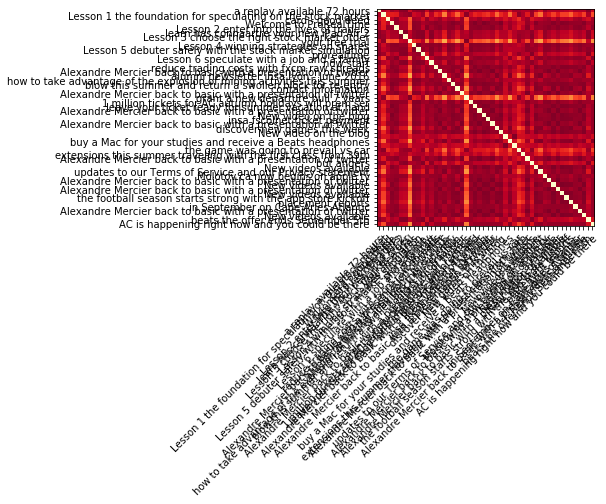

In [25]:
f_c.heat_map(subjects_similarity, labels)

/content/GreenMail/clustering/func_clustering.py:99: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


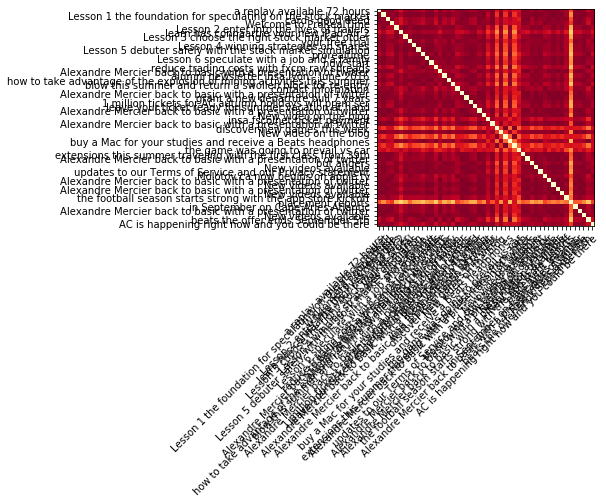

In [26]:
f_c.heat_map(texts_similarity, labels)

/content/GreenMail/clustering/func_clustering.py:99: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


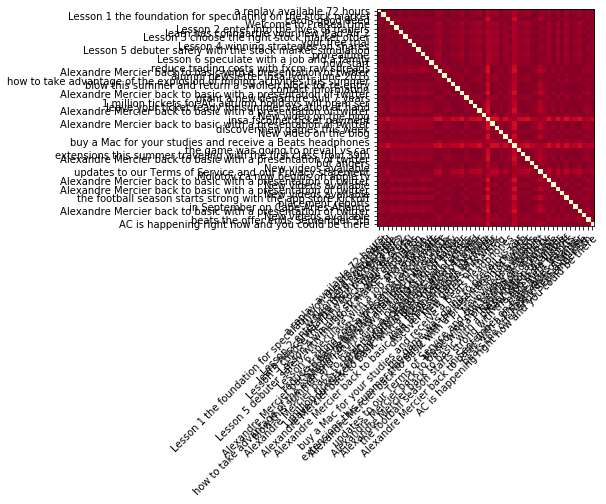

In [27]:
f_c.heat_map(address_similarity, labels)

In [0]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [0]:
def display_dendrogram(similarity_matrix, labels, method='weighted'):
  distVec = ssd.squareform(similarity_matrix)
  link = linkage(y=(1 - distVec), method=method)
  link[link < 0] = 0
  dendro  = dendrogram(link, labels=labels)
  plt.show()

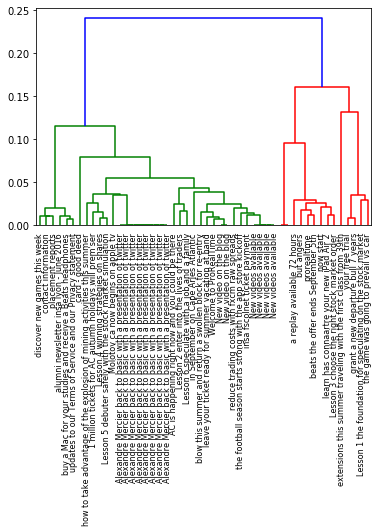

In [30]:
display_dendrogram(subjects_similarity, labels)

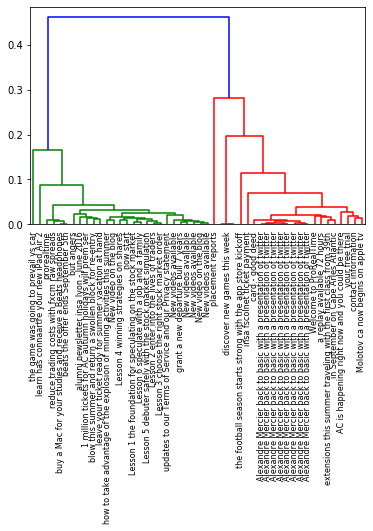

In [31]:
display_dendrogram(texts_similarity, labels)

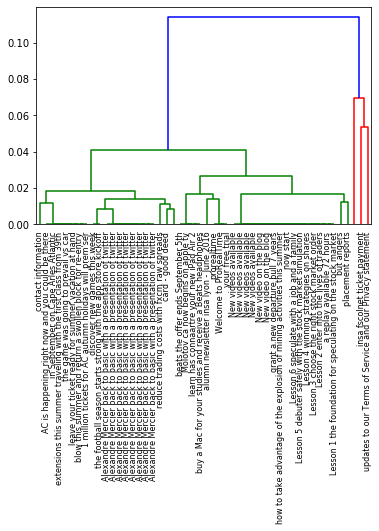

In [32]:
display_dendrogram(address_similarity, labels)

In [0]:
all_similarity = (texts_similarity + address_similarity)/2

In [41]:
all_similarity.shape

(50, 50)

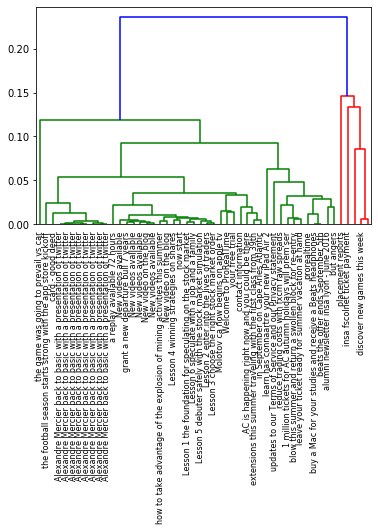

In [42]:
display_dendrogram(all_similarity, labels)